A1 — Entropy: 2.0
A2 — Gini: 0.6875
A3 — Best root feature: Fp1.__delta (IG = 0.002342)
A4 — Equal-width bins: 4
A4 — Equal-frequency bins: 4
A5 — ID3 training accuracy: 0.501
A6 — Fixed 2 features: ['Af3.__delta', 'Af4.__delta']


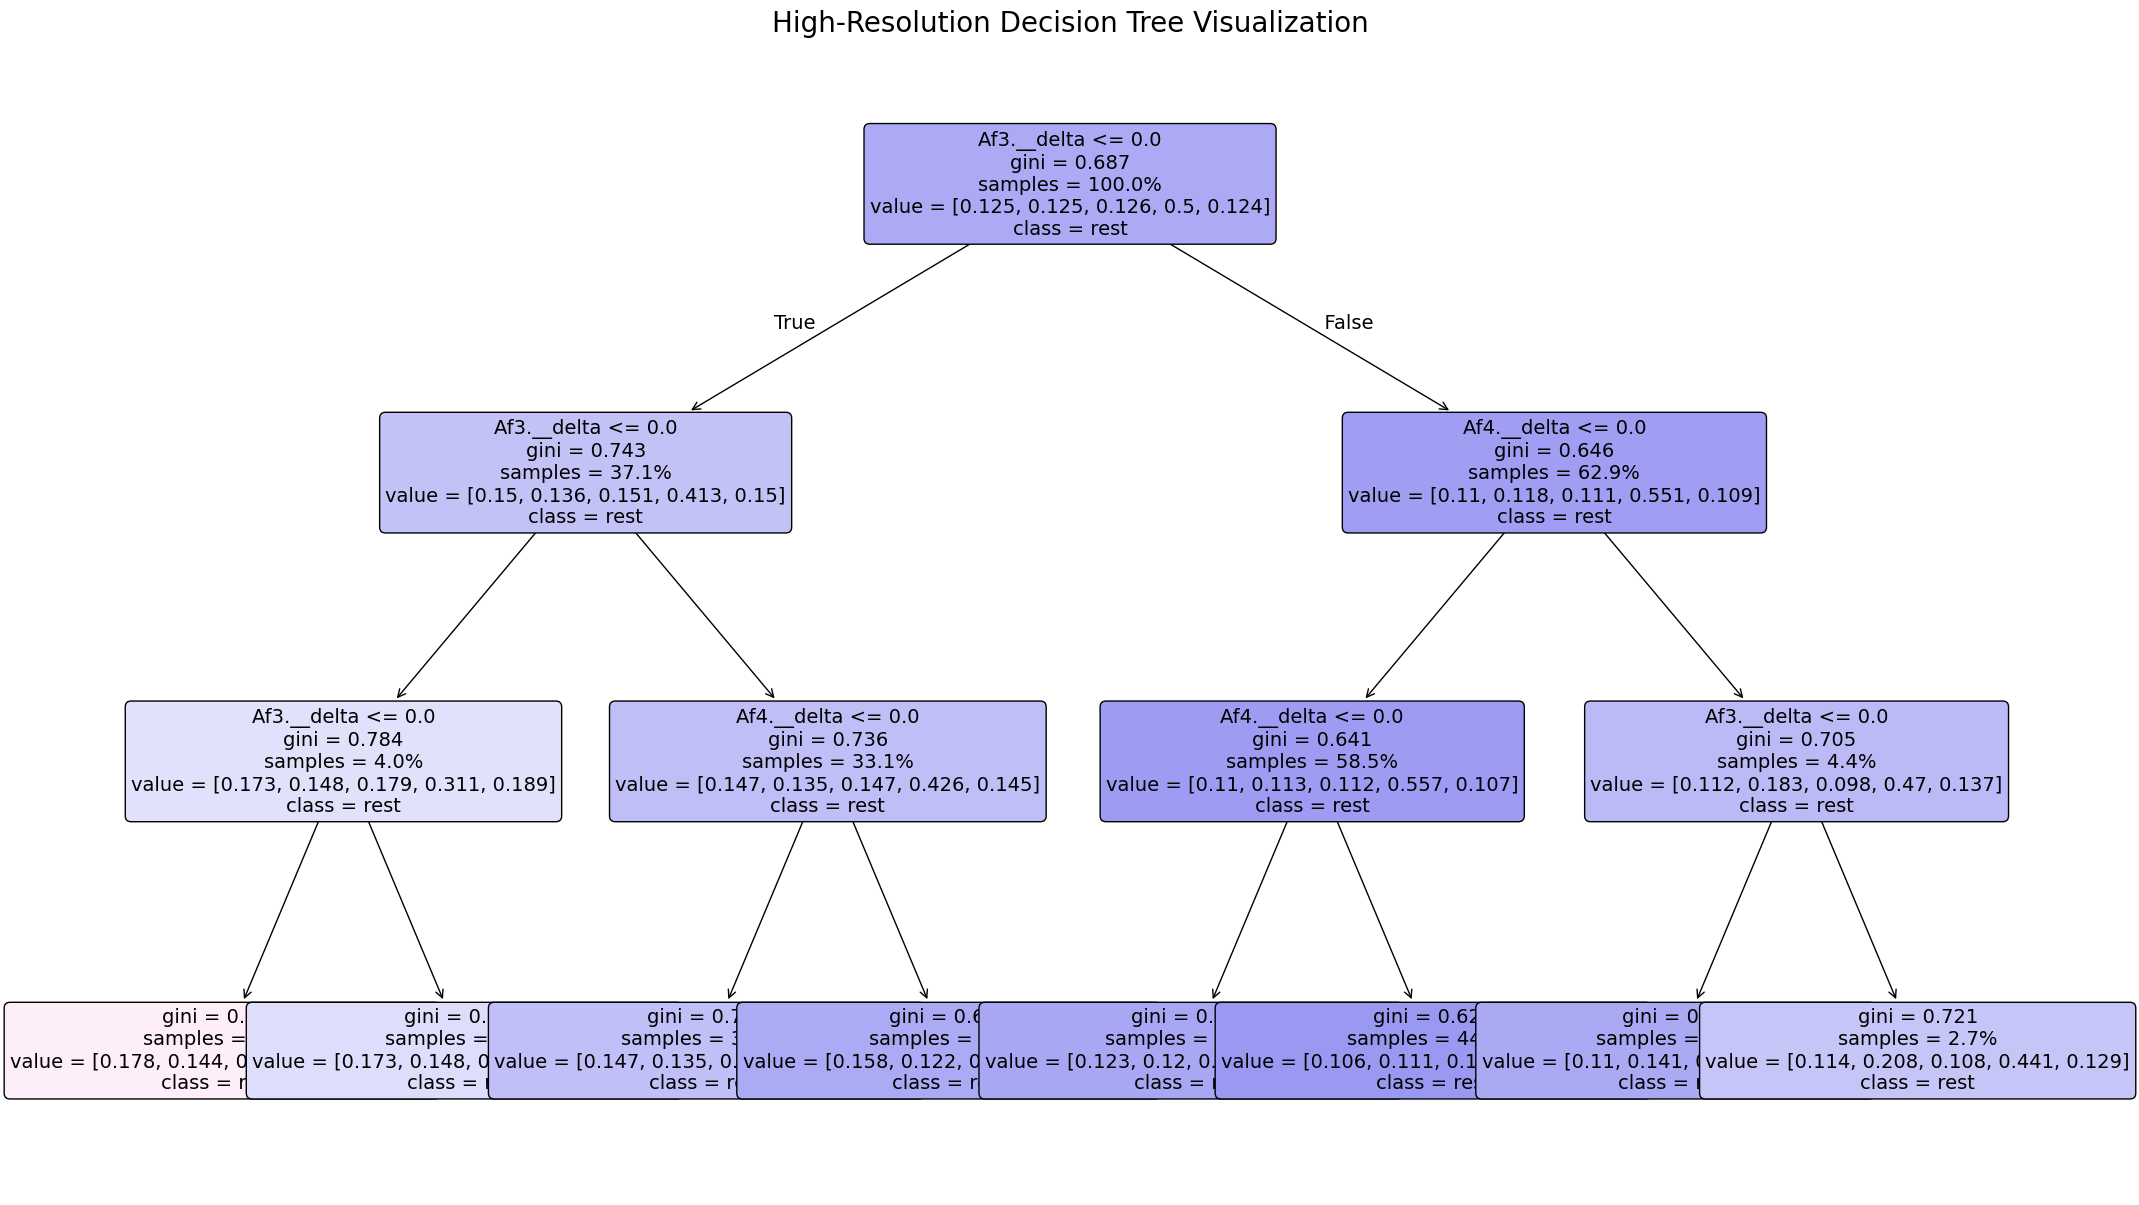

A7 — Decision boundary:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


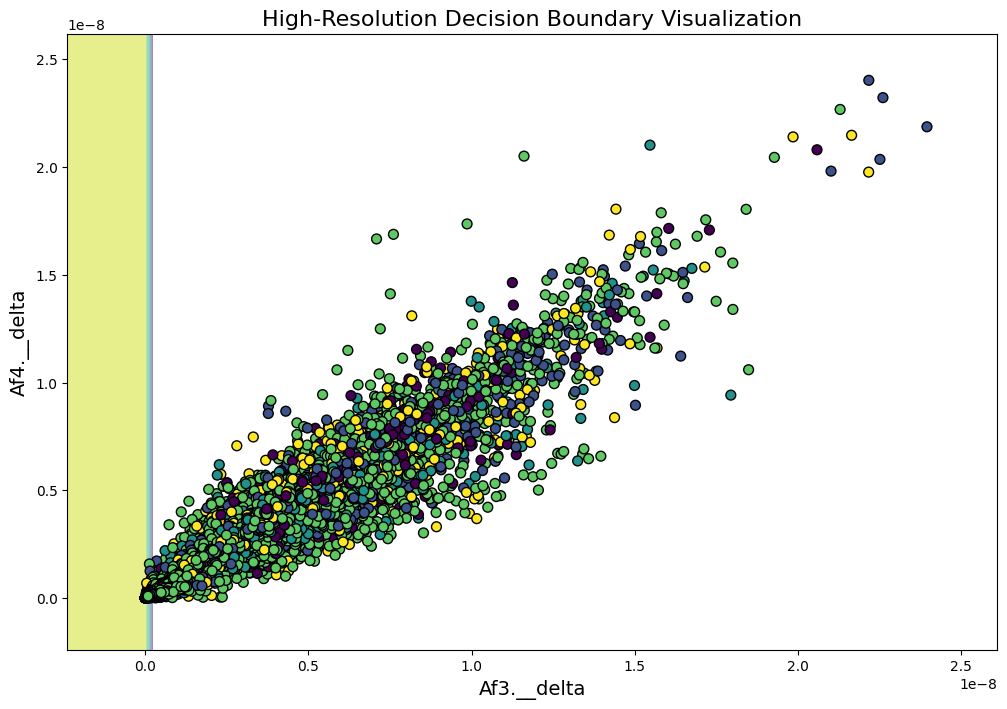

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# A4: Binning utilities — turn continuous variables into categories

def bin_equal_width(series: pd.Series, n_bins: int = 4) -> pd.Series:
    """
    Equal-width binning for continuous data.
    Splits the range of values into n_bins of equal size.
    """
    # converting input to numeric (any invalid entry like strings becomes NaN and split into n_bins equal width intervals)
    s = pd.to_numeric(series, errors="coerce")
    # if the series has only one unique value (or all values missing), it returns a new series filled with zero (i.e all values assigned to same bin)
    if s.dropna().nunique() <= 1:
        return pd.Series(0, index=s.index)
    # pd.cut splits into equal-width bins
    # labels=False assign the bin numbers 0,1,2.. etc
    # duplicates="drop" handles repeated bin edges, in case the data range is too small → drop them safely
    return pd.cut(
        s, bins=n_bins, labels=False, include_lowest=True, duplicates="drop"
    ).fillna(0).astype(int)  # Missing values (from NaN in input) are assigned bin 0.

def bin_equal_frequency(series: pd.Series, n_bins: int = 4) -> pd.Series:
    """
    Equal-frequency binning (quantiles).
    Each bin gets ~same number of samples.
    """
    # converts input to numeric and non-numeric values become NaN
    s = pd.to_numeric(series, errors="coerce")
    # counts unique numeric values
    # if all values are the same, quantile binning makes no sense
    uniq = s.dropna().nunique()
    if uniq <= 1:  # if series has 1 or 0, return a series of all 0 (one bin)
        return pd.Series(0, index=s.index)
    bins = min(n_bins, max(2, uniq))  # At least 2 bins, max=unique count, for splitting
    try:
        return pd.qcut(  # equal frequency binning
            s, q=bins, labels=False, duplicates="drop"
        ).fillna(0).astype(int)  # missing values get bin 0 and convert bin indices to integers
    except Exception:
        # If quantile binning fails, fall back to equal-width
        return bin_equal_width(series, n_bins=bins)

def bin_series(series: pd.Series, n_bins: int = 4, method: str = "width") -> pd.Series:
    """Wrapper for choosing width or frequency binning."""
    if method == "frequency":
        return bin_equal_frequency(series, n_bins=n_bins)  # If user specifies "frequency", call equal-frequency binning
    return bin_equal_width(series, n_bins=n_bins)



# A1 & A2: Measures of impurity — Entropy, Gini, Misclassification


def entropy(y: pd.Series) -> float:
    """Compute entropy of a categorical variable y."""
    # getting the unique classes and their counts
    # high entropy → mixed classes (uncertain)
    # low entropy → pure class (certain)
    values, counts = np.unique(y.dropna(), return_counts=True)
    if counts.size == 0:  # empty series → entropy = 0
        return 0.0
    # converts the counts to probabilities (relative frequencies)
    probs = counts / counts.sum()
    # Apply entropy formula: H = -Σ p * log2(p)
    return float(-(probs * np.log2(probs)).sum())

def gini_index(y: pd.Series) -> float:
    """Compute Gini index of a categorical variable y."""
    # getting the unique classes and their counts
    values, counts = np.unique(y.dropna(), return_counts=True)
    # empty series → impurity = 0
    if counts.size == 0:
        return 0.0
    probs = counts / counts.sum()
    return float(1.0 - (probs**2).sum())  # Gini = 1 - sum(p^2)

def misclassification_rate(y: pd.Series) -> float:
    """Misclassification = 1 - proportion of majority class."""
    # getting the unique classes and their counts
    values, counts = np.unique(y.dropna(), return_counts=True)
    # empty series → misclassification = 0
    if counts.size == 0:
        return 0.0
    return float(1.0 - counts.max() / counts.sum())



# A3: Information Gain & best root feature selection


def information_gain(target: pd.Series, feature_cat: pd.Series) -> float:
    """
    Compute Information Gain IG(target; feature).
    Assumes feature_cat is already categorical (binned if needed).
    """
    # target: class labels 0/1
    base = entropy(target)  # entropy before the dataset split
    weighted = 0.0
    for v, count in zip(*np.unique(feature_cat, return_counts=True)):
        subset = target[feature_cat == v]  # takes only the labels belonging to that bin/category
        weighted += (count / len(target)) * entropy(subset)
    return float(base - weighted)  # IG = base - weighted avg

def best_root_feature(
    X_num: pd.DataFrame, y: pd.Series, n_bins: int = 4, binning_method: str = "width"
) -> Tuple[str, float, pd.Series]:
    """
    Find the numeric feature with highest information gain when binned.
    Returns (name, IG value, binned series).
    """
    best_name, best_gain, best_binned = None, -np.inf, None
    # converting x_num into categorical bins using bin_series and computing IG between y and this binned feature
    # if IG is higher than the current best, update best feature
    for col in X_num.columns:
        binned = bin_series(X_num[col], n_bins=n_bins, method=binning_method)
        gain = information_gain(y, binned)
        if gain > best_gain:
            best_name, best_gain, best_binned = col, gain, binned
    return best_name, best_gain, best_binned


# A5: Minimal ID3 decision tree implementation (educational)

@dataclass
class DTNode:
    feature: Optional[str] = None              # feature to split on
    children: Optional[Dict[int, "DTNode"]] = None  # bin_value -> child
    prediction: Optional[int] = None           # predicted class if it's a leaf node

def majority_class(y: pd.Series) -> int:
    """Return the most common class label in y."""
    # finding the most frequent class in the target labels y
    # used as a fallback when we hit a leaf node or cannot split further
    vals, counts = np.unique(y, return_counts=True)
    return int(vals[np.argmax(counts)])

def id3_fit(X_binned: pd.DataFrame, y: pd.Series, depth: int = 0, max_depth: int = 3) -> DTNode:
    """
    Recursive ID3 on binned data.
    Stops when:
      - All labels are the same
      - No features left
      - Max depth reached
    """
    # if all target values same → return a leaf node with that class
    # if max depth reached → stop growing and return majority class
    # if no features left → return a leaf with majority class
    if y.nunique() == 1 or depth >= max_depth or X_binned.shape[1] == 0:
        return DTNode(prediction=majority_class(y))

    # finds the feature with highest information gain and if no feature found → return the majority class leaf
    best_col, _, _ = best_root_feature(X_binned, y, n_bins=2, binning_method="width")
    if best_col is None:
        return DTNode(prediction=majority_class(y))

    # if no samples fall in a bin of the chosen feature, assign a child leaf with majority class
    # otherwise recurse
    node = DTNode(feature=best_col, children={})
    for bin_val in sorted(X_binned[best_col].unique()):
        mask = X_binned[best_col] == bin_val
        if mask.sum() == 0:
            node.children[int(bin_val)] = DTNode(prediction=majority_class(y))
        else:
            child_X = X_binned.loc[mask].drop(columns=[best_col])
            child_y = y.loc[mask]
            node.children[int(bin_val)] = id3_fit(child_X, child_y, depth + 1, max_depth)
    return node

# start at root node and at each node loop the feature value of the row, follow the corresponding child node
def id3_predict_one(node: DTNode, row: pd.Series) -> int:
    """Traverse tree to predict label for one row."""
    while node and node.feature is not None:
        val = int(row[node.feature])
        if node.children is None or val not in node.children:
            break
        node = node.children[val]
    return node.prediction if node and node.prediction is not None else 0

# loop through all rows in X_binned → for each row call id3_predict_one and collect result into numpy array for prediction
def id3_predict(node: DTNode, X_binned: pd.DataFrame) -> np.ndarray:
    """Predict for multiple rows."""
    return np.array([id3_predict_one(node, X_binned.iloc[i]) for i in range(len(X_binned))])



# A6: Visualization helpers using sklearn


def train_sklearn_tree(X: pd.DataFrame, y: pd.Series, max_depth: int = 4) -> DecisionTreeClassifier:
    """Fit a sklearn DecisionTreeClassifier."""
    # creates a decision tree classifier with max_depth=4 (not grow more than 4 to avoid overfitting)
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    clf.fit(X, y)  # train the tree on feature X and label y
    return clf


# A7: Decision boundary for 2D feature space


def show_decision_boundary_2d(clf: DecisionTreeClassifier, X2: pd.DataFrame, y_enc: np.ndarray, feature_names: List[str]) -> None:
    """Plot 2D decision boundary for two features."""
    # get feature ranges
    x_min, x_max = X2.iloc[:, 0].min(), X2.iloc[:, 0].max()
    y_min, y_max = X2.iloc[:, 1].min(), X2.iloc[:, 1].max()
    x_range, y_range = x_max - x_min, y_max - y_min

    # meshgrid to create gridpoints in that region and predict the class for every gridpoint
    xx, yy = np.meshgrid(
        np.arange(x_min - 0.1 * x_range, x_max + 0.1 * x_range, x_range / 100),
        np.arange(y_min - 0.1 * y_range, y_max + 0.1 * y_range, y_range / 100)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    # reshape predictions to the grid shape
    zz = clf.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(12, 8))
    # shows the decision regions (shaded areas)
    plt.contourf(xx, yy, zz, alpha=0.5, cmap=plt.cm.viridis)
    # overlay training samples
    plt.scatter(X2.iloc[:, 0], X2.iloc[:, 1], c=y_enc, s=50, edgecolor="k", cmap=plt.cm.viridis)
    plt.xlabel(feature_names[0], fontsize=14)
    plt.ylabel(feature_names[1], fontsize=14)
    plt.title("High-Resolution Decision Boundary Visualization", fontsize=16)
    plt.savefig("decision_boundary_high_res.png", dpi=300)
    plt.show()


# Data preparation utility

def split_features_target(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """Separate numeric feature columns from the label column."""
    non_features = {"file", "run", "label", "onset_s"}  # columns with these not used as features
    numeric_cols = [c for c in df.columns if c not in non_features]
    X = df[numeric_cols].apply(pd.to_numeric, errors="coerce")  # converting feature columns to numeric and replacing non-numeric with NaN
    y = df["label"].astype(str)
    mask = y.notna()  # remove rows with missing labels
    return X.loc[mask], y.loc[mask]


# Main script


if __name__ == "__main__":
    # Loading the dataset
    csv_path = "/content/features_filtered.csv"
    df = pd.read_csv(csv_path)

    # Split into numeric features and labels
    # X_num = numeric features
    # y_str = target labels as strings
    X_num, y_str = split_features_target(df)

    # converting string labels into integers
    # Encode labels as integers for sklearn
    le = LabelEncoder()
    y_enc = le.fit_transform(y_str)  # array of integer labels
    class_names = list(le.classes_)

    # A1 & A2: Entropy & Gini
    target_entropy = entropy(y_str)
    target_gini = gini_index(y_str)
    print("A1 — Entropy:", round(target_entropy, 4))
    print("A2 — Gini:", round(target_gini, 4))  # gini index → probability of misclassifying a randomly chosen element

    #  A3: Best root feature by IG
    root_name, root_gain, _ = best_root_feature(X_num, y_str, n_bins=4, binning_method="width")
    print(f"A3 — Best root feature: {root_name} (IG = {root_gain:.6f})")

    # A4: Show binning results for root feature
    root_binned_width = bin_series(X_num[root_name], 4, "width")
    root_binned_freq = bin_series(X_num[root_name], 4, "frequency")
    # equal-width → divides the range into bins of same size
    print("A4 — Equal-width bins:", int(root_binned_width.max() + 1))
    # equal-frequency → divides data so each bin has roughly same number of samples
    print("A4 — Equal-frequency bins:", int(root_binned_freq.max() + 1))

    # A5: Train tiny ID3 tree on all binned features
    # equal width binning with n_bin=4
    X_binned = X_num.apply(lambda s: bin_series(s, 4, "width"))
    tiny_tree = id3_fit(X_binned, pd.Series(y_enc, index=X_binned.index), max_depth=3)
    preds_id3 = id3_predict(tiny_tree, X_binned)
    acc_id3 = (preds_id3 == y_enc).mean()
    print(f"A5 — ID3 training accuracy: {acc_id3:.3f}")

    # A6: Train sklearn tree on fixed features Af3.__delta and Af4.__delta
    top2 = ["Af3.__delta", "Af4.__delta"]
    X2 = X_num[top2].fillna(X_num[top2].median())  # handle missing values
    clf2 = train_sklearn_tree(X2, y_enc, max_depth=3)
    print("A6 — Fixed 2 features:", top2)

    # Show decision tree (high resolution)
    plt.figure(figsize=(25, 15))
    plot_tree(
        clf2,
        feature_names=top2,
        class_names=class_names,
        filled=True,
        rounded=True,
        fontsize=14,
        proportion=True
    )
    plt.title("High-Resolution Decision Tree Visualization", fontsize=20)
    plt.savefig("decision_tree_high_res.png", dpi=300)
    plt.show()

    # A7: Plot decision boundary for those 2 features
    print("A7 — Decision boundary:")
    show_decision_boundary_2d(clf2, X2, y_enc, top2)
